# Unsupervised Outlier Detection - AutoEncoder

## Importing Libraries

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

from keras import models
from keras import utils
from keras import layers as L

plt.style.use('seaborn-v0_8-dark')

## Generating Data

In [2]:
contamination = 0.05   # porcentagem de outlierts
n_train = 4500         # observações de treino
n_features = 5         # quantidade de features

In [3]:
X, y = generate_data(
    n_train=n_train,
    train_only=True,
    n_features=n_features,
    contamination=contamination,
    random_state=42
)

In [4]:
data = (
    pd.DataFrame(X)
    .assign(target=y)
    .rename(columns={0:'x0',1:'x1',2:'x2',3:'x3',4:'x4'})
)

X_train, X_test, y_train, y_test = train_test_split(data.drop('target',axis=1), data.target, stratify=y, test_size=0.2)

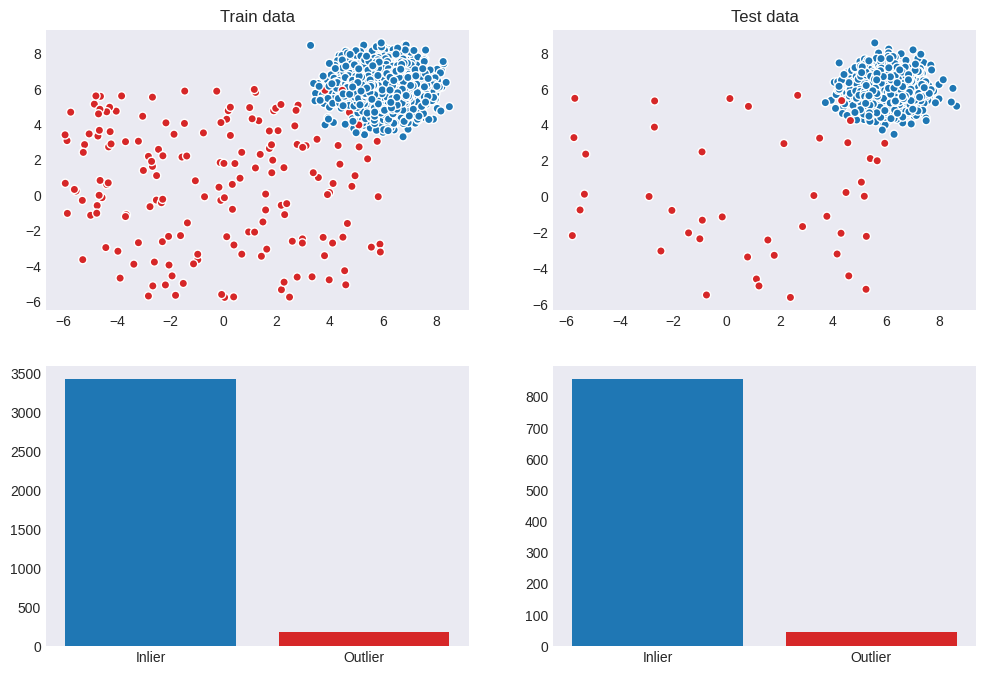

In [5]:
f, ax = plt.subplots(2, 2, figsize=(12,8))

train_plot = (
    pd
    .DataFrame(X_train)
    .assign(target=y_train)
    .rename(columns={0:'x1',1:'x2'})
)

test_plot =  (
    pd
    .DataFrame(X_test)
    .assign(target=y_test)
    .rename(columns={0:'x1',1:'x2'})
)


for idx,dataset in enumerate([train_plot, test_plot]):
    ##scatter
    ax[0,idx].scatter(dataset.x1, dataset.x2, c=['tab:blue' if x==0 else 'tab:red' for x in dataset.target], edgecolors='white')
    
    ##barplot
    count_data = dataset.target.value_counts()
    ax[1,idx].bar([0,1], count_data, color=['tab:blue','tab:red'])
    ax[1,idx].set_xticks([0,1])
    ax[1,idx].set_xticklabels(['Inlier','Outlier'])


ax[0,0].set_title('Train data')
ax[0,1].set_title('Test data')

plt.show()

In [87]:
data_pipe = make_pipeline(Normalizer(),MinMaxScaler(feature_range=(-1,1)))

In [88]:
data_pipe.fit(X_train)

Pipeline(steps=[('normalizer', Normalizer()),
                ('minmaxscaler', MinMaxScaler(feature_range=(-1, 1)))])

In [89]:
X_train_scaled = data_pipe.transform(X_train)
X_test_scaled  = data_pipe.transform(X_test)

## The process

Model Development --> Threshold Determination --> Profile the Normal and Outlier Groups

In [91]:
ae_layers = [32,16,8,4]
bn_dim = 2

#### INPUT LAYER ####
i_layer = L.Input(shape=(X_train_scaled.shape[1],))

#### ENCODER ####
x = L.Dense(ae_layers[0], activation='tanh')(i_layer)
for layer in ae_layers[1:]:
    x = L.Dense(layer, activation='tanh')(x)
    
#### Bottleneck ####
bn = L.Dense(bn_dim, activation='tanh')(x)
    
#### DECODER ####
dec = L.Dense(ae_layers[-1], activation='tanh')(bn)
for layer in ae_layers[-2::-1]:
    dec = L.Dense(layer, activation='tanh')(dec)   
    
#### OUTPUT ####
output = L.Dense(X_train_scaled.shape[1],activation='tanh')(dec)

In [92]:
#### MODELS DEFINITION ####

autoencoder = models.Model(i_layer,output)
encoder = models.Model(i_layer,bn)
decoder = models.Model(bn,output)

autoencoder.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_122 (Dense)           (None, 32)                192       
                                                                 
 dense_123 (Dense)           (None, 16)                528       
                                                                 
 dense_124 (Dense)           (None, 8)                 136       
                                                                 
 dense_125 (Dense)           (None, 4)                 36        
                                                                 
 dense_126 (Dense)           (None, 2)                 10        
                                                                 
 dense_127 (Dense)           (None, 4)                 12 

![](https://miro.medium.com/max/777/1*ce89U6z-MhgGRln9VRAMxQ.png)

In [93]:
autoencoder.compile(optimizer='adagrad', loss='mean_squared_error')

model_history = autoencoder.fit(X_train_scaled,
                                X_train_scaled,
                                epochs=500,
                                validation_data=(X_test,X_test_scaled),
                                verbose=0)

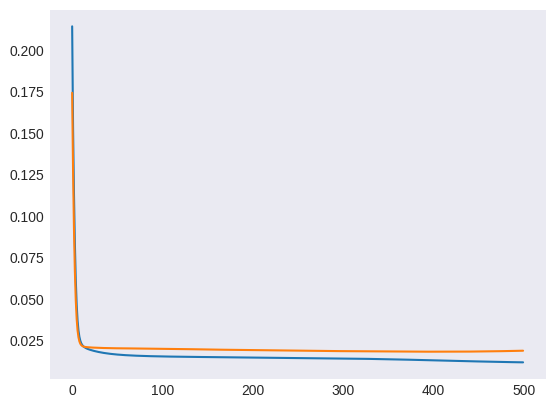

In [94]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])

In [96]:
data = X_train_scaled[0]
encoded_data = encoder.predict(data.reshape(1,5))
reconstructed_data = autoencoder.predict(data.reshape(1,5))

1/1 [==============================] - 0s 42ms/step


In [98]:
display(data)
display(encoded_data[0])
display(reconstructed_data[0])

array([0.50245754, 0.47681521, 0.51149997, 0.55617677, 0.46801592])

array([-0.6498109 , -0.01375682], dtype=float32)

array([0.4937861 , 0.42729762, 0.4765559 , 0.52744406, 0.58360773],
      dtype=float32)

In [104]:
scores = np.mean((X_train_scaled - autoencoder.predict(X_train_scaled))**2,axis=1)

29/29 [==============================] - 0s 663us/step


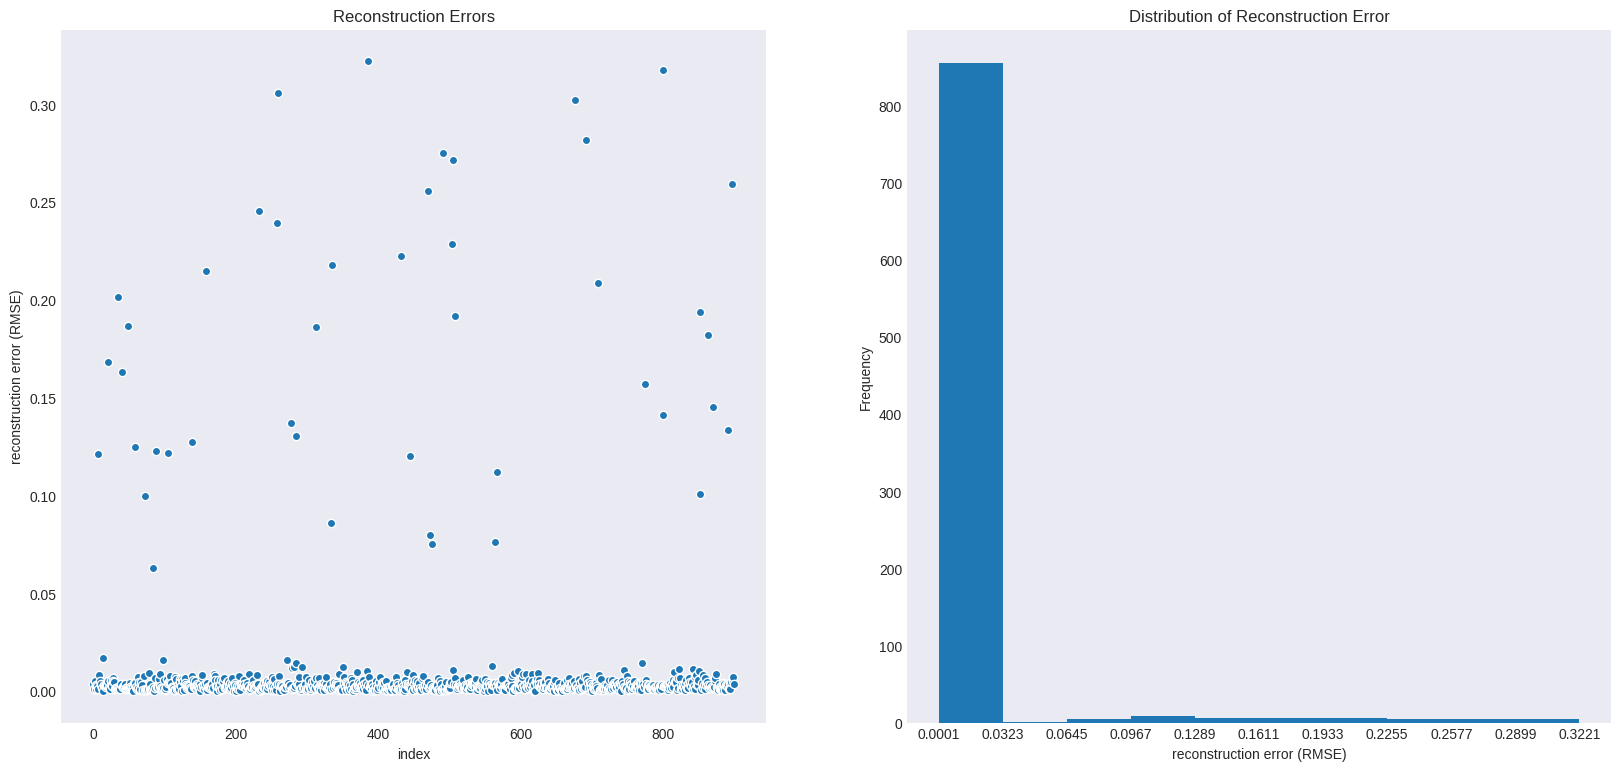

In [116]:
f, ax = plt.subplots(1,2, figsize=(20,9))

data_plot = (
    pd.DataFrame(scores)
    .assign(target=y_train.values)
    .rename(columns={0:'rec_score'})
)

ax[0].scatter(range(len(data_plot.rec_score)),data_plot.rec_score, edgecolors='white')
ax[0].set_title('Reconstruction Errors')
ax[0].set_ylabel('reconstruction error (RMSE)')
ax[0].set_xlabel('index')

_, bins, _ = ax[1].hist(scores, align='mid')
ax[1].set_xticks(bins)

ax[1].set_title('Distribution of Reconstruction Error')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('reconstruction error (RMSE)')

plt.show()

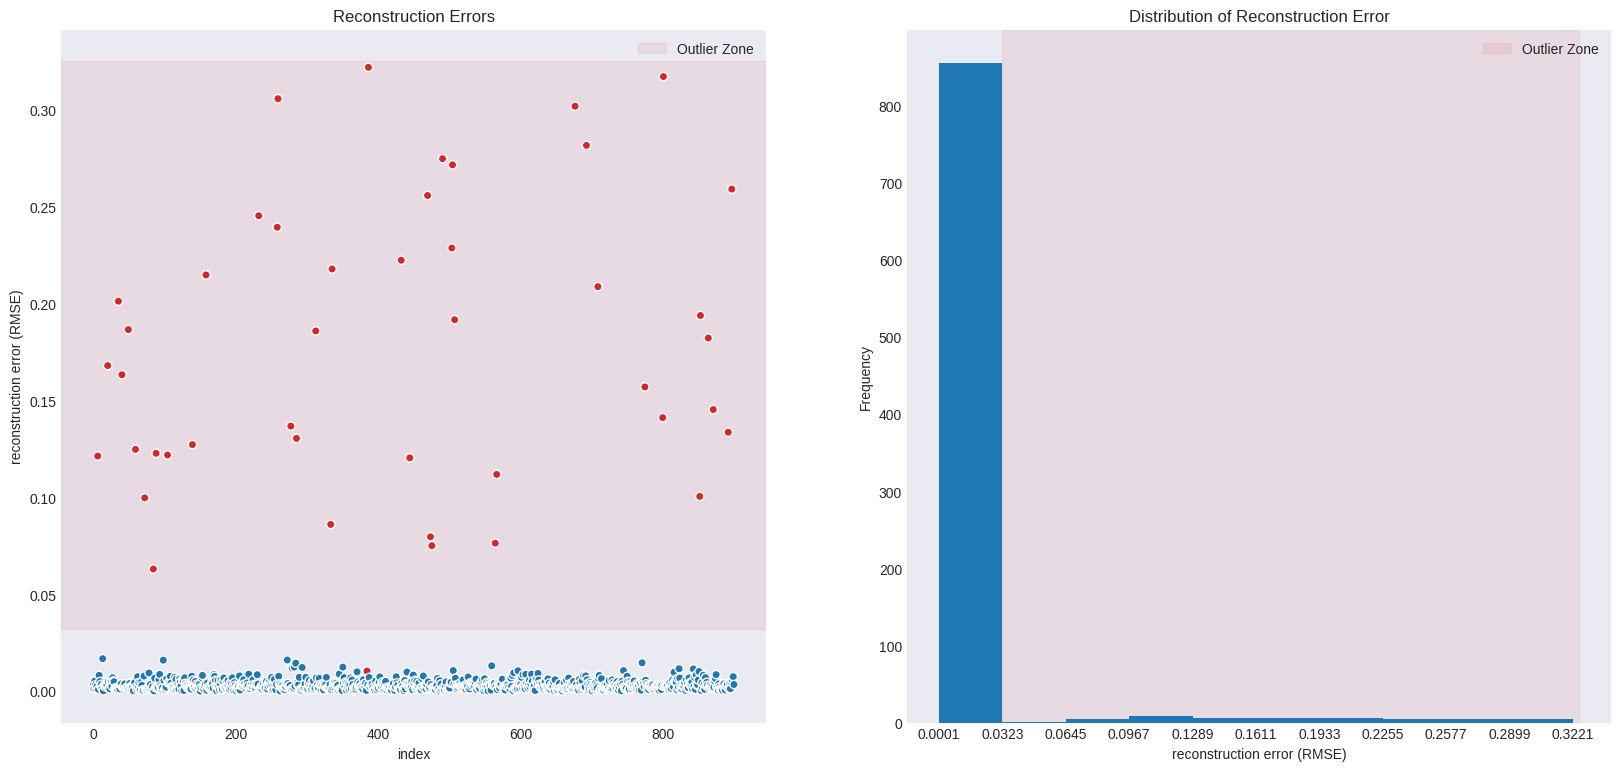

In [133]:
limite = 0.0323

f, ax = plt.subplots(1,2, figsize=(20,9))

data_plot = (
    pd.DataFrame(scores)
    .assign(target=y_train.values)
    .rename(columns={0:'rec_score'})
)

ax[0].scatter(
    range(len(data_plot.rec_score)),
    data_plot.rec_score, 
    edgecolors='white', 
    c=['tab:blue' if x==0 else 'tab:red' for x in data_plot.target]
)

ax[0].axhspan(limite,
              data_plot.rec_score.max()*1.01,
              zorder=-1,
              alpha=0.08,
              color='tab:red',
              label='Outlier Zone')

ax[0].legend(loc=1)

ax[0].set_title('Reconstruction Errors')
ax[0].set_ylabel('reconstruction error (RMSE)')
ax[0].set_xlabel('index')

_, bins, _ = ax[1].hist(scores, align='mid')

ax[1].axvspan(limite,
              data_plot.rec_score.max()*1.01,
              zorder=-1,
              alpha=0.08,
              color='tab:red',
              label='Outlier Zone')

ax[1].legend(loc=1)
ax[1].set_xticks(bins)
ax[1].set_title('Distribution of Reconstruction Error')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('reconstruction error (RMSE)')

plt.show()

In [152]:
data_pred = (
    data_plot.assign(
        out_predict = lambda x: x.rec_score.apply(lambda z: 0 if z <= limite else 1)
    )
)

data_pred.sample(10)

,rec_score,target,out_predict
122,0.004733,0.0,0
531,0.004510,0.0,0
72,0.099820,1.0,1
146,0.002442,0.0,0
537,0.006297,0.0,0
54,0.000878,0.0,0
269,0.002148,0.0,0
145,0.003594,0.0,0
389,0.001889,0.0,0
298,0.007164,0.0,0


In [153]:
print(classification_report(data_pred.target,data_pred.out_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       855
         1.0       1.00      0.98      0.99        45

    accuracy                           1.00       900
   macro avg       1.00      0.99      0.99       900
weighted avg       1.00      1.00      1.00       900

